In [1]:
!pip install pennylane
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.7/54.7 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 16.0 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.10.1
    Uninstalling scipy-1.10.1:
      Successfully uninstalled scipy-1.10.1
  Attempting uninstall: autograd
    Found existing installation: autograd 1.6.2
    Uninstalling autograd-1.6.2:
      Successfully uninstalled autograd-1.6.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 42.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/

In [17]:
import pennylane as qml
import torch
from torch import Tensor
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

from transformers import AutoTokenizer

from torch.utils.data import DataLoader, Dataset
from tensorflow import compat
import tensorflow_datasets as tfds
import scipy

from pathlib import Path
import pandas as pd
from joblib import load, dump
from sklearn.model_selection import train_test_split

from torch.utils.data import DataLoader, Dataset
import torch.utils.data as data_utils

from collections import Counter

In [3]:
!git clone https://github.com/CQCL/qnlp_lorenz_etal_2021_resources
!mv qnlp_lorenz_etal_2021_resources/datasets mc_rp_dataset

Cloning into 'qnlp_lorenz_etal_2021_resources'...
remote: Enumerating objects: 93, done.
remote: Counting objects: 100% (93/93), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 93 (delta 41), reused 57 (delta 25), pack-reused 0
Receiving objects: 100% (93/93), 56.79 KiB | 7.10 MiB/s, done.
Resolving deltas: 100% (41/41), done.


In [4]:
mc_rp_sets_path = Path("mc_rp_dataset")
mc_rp_sets = list(mc_rp_sets_path.glob("*.txt"))
mc_datasets, rp_datasets = list(filter(lambda x: x.name.startswith("mc"), mc_rp_sets)), list(filter(lambda x: x.name.startswith("rp"), mc_rp_sets))

In [5]:
def read_process_mcrp(datapaths: dict):
  def rm(text):
    return " ".join(list(map(lambda x: x[:x.find('_')], text.split())))
  retval = {}
  for datapath in datapaths:
    if "rp" in str(datapath):
      sel = 2
    else:
      sel = 3
    df = pd.DataFrame(list(map(lambda x: [int(x[0]), x[sel:]], datapath.read_text().split("\n"))), columns=['label', 'text'])
    df['text'] = df['text'].apply(rm)
    retval[datapath.name.split(".")[0]] = df
  return retval

mc_data, rp_data = read_process_mcrp(mc_datasets), read_process_mcrp(rp_datasets)
MRP_BATCH_SIZE = 30

In [6]:
def data_frame_simple_txt2vec(data,keystr,shape,min_length=4,w_dict=None):
    txt_lst=[]
    max_len=0
    for txt in data[keystr].text:
        txtsplit=txt.split()
        txt_lst=txt_lst+txtsplit
        if max_len< len(txtsplit):
            max_len=len(txtsplit)
    w_set=set(txt_lst)

    comm_lst=Counter(txt_lst).most_common()

    if w_dict==None:
        w_dict={}
        ind=len(comm_lst)
        for elem in comm_lst:
            w_dict[elem[0]]=ind
            ind-=1
    #w_dict={}
    #ind=1
    #for elem in w_set:
    #    w_dict[elem]=ind
    #    ind+=1

    if max_len%2 !=0:
        max_len+=1
    if max_len<min_length:
        max_len=min_length

    label_list=[]
    Txt_list=[]
    for i, txt in enumerate(data[keystr].text):
        w_list=[]
        for word in data[keystr].text[i].split():
            if word in w_dict:
                w_list.append(w_dict[word])
            else:
                w_list.append(len(w_dict.keys())+1)
        if len(w_list) < max_len:
            w_list=w_list+(max_len-len(w_list))*[0]
        #print(torch.tensor(w_list))
        label_list.append(torch.tensor(data[keystr].label[i]))
        Txt_list.append(torch.tensor(w_list).reshape(shape)*np.pi/len(comm_lst)/2)
    label_tensor=torch.tensor(label_list)
    txt_tensor=torch.stack(Txt_list)

    return data_utils.TensorDataset(txt_tensor,label_tensor),w_dict

In [7]:
shape=(4)

mc_df_train,train_dict=data_frame_simple_txt2vec(mc_data,'mc_train_data',shape)
mc_df_test,_=data_frame_simple_txt2vec(mc_data,'mc_test_data',shape,w_dict=train_dict)

mc_trainloader = DataLoader(mc_df_train, shuffle=True, batch_size=30)
mc_testloader = DataLoader(mc_df_test, shuffle=True, batch_size=30)

In [8]:
import functools
import inspect
import math
from collections.abc import Iterable
from typing import Callable, Dict, Union, Any

from pennylane.qnode import QNode

try:
    import torch
    from torch.nn import Module

    TORCH_IMPORTED = True
except ImportError:
    # The following allows this module to be imported even if PyTorch is not installed. Users
    # will instead see an ImportError when instantiating the TorchLayer.
    from unittest.mock import Mock

    Module = Mock
    TORCH_IMPORTED = False


class TorchLayer(Module):
    def __init__(self,qnode,weights):
        if not TORCH_IMPORTED:
            raise ImportError(
                "TorchLayer requires PyTorch. PyTorch can be installed using:\n"
                "pip install torch\nAlternatively, "
                "visit https://pytorch.org/get-started/locally/ for detailed "
                "instructions."
            )
        super().__init__()

        #weight_shapes = {
        #    weight: (tuple(size) if isinstance(size, Iterable) else () if size == 1 else (size,))
        #    for weight, size in weight_shapes.items()
        #}

        # validate the QNode signature, and convert to a Torch QNode.
        # TODO: update the docstring regarding changes to restrictions when tape mode is default.
        #self._signature_validation(qnode, weight_shapes)
        self.qnode = qnode
        self.qnode.interface = "torch"

        self.qnode_weights = weights

    def forward(self, inputs):  # pylint: disable=arguments-differ
        """Evaluates a forward pass through the QNode based upon input data and the initialized
        weights.

        Args:
            inputs (tensor): data to be processed

        Returns:
            tensor: output data
        """

        if len(inputs.shape) > 1:
            # If the input size is not 1-dimensional, unstack the input along its first dimension,
            # recursively call the forward pass on each of the yielded tensors, and then stack the
            # outputs back into the correct shape
            reconstructor = [self.forward(x) for x in torch.unbind(inputs)]
            return torch.stack(reconstructor)

        # If the input is 1-dimensional, calculate the forward pass as usual
        return self._evaluate_qnode(inputs)


    def _evaluate_qnode(self, x):
        """Evaluates the QNode for a single input datapoint.

        Args:
            x (tensor): the datapoint

        Returns:
            tensor: output datapoint
        """
        kwargs = {
            **{self.input_arg: x},
            **{arg: weight.to(x) for arg, weight in self.qnode_weights.items()},
        }
        res = self.qnode(**kwargs)

        if isinstance(res, torch.Tensor):
            return res.type(x.dtype)

        return torch.hstack(res).type(x.dtype)

    def __str__(self):
        detail = "<Quantum Torch Layer: func={}>"
        return detail.format(self.qnode.func.__name__)

    __repr__ = __str__
    _input_arg = "inputs"

    @property
    def input_arg(self):
        """Name of the argument to be used as the input to the Torch layer. Set to ``"inputs"``."""
        return self._input_arg

In [9]:
class qrnn(torch.nn.Module):
    def __init__(self, anc_q, n_qub_enc, seq_num, D):
        """
        # n_qub_enc: # of of qubits for encodong input
        # anc_q: # of of qubits for memerizing history
        # seq_num: How many pieces the text is divided.
        # D: the # of layers of variational layers
        """
        super().__init__()
        self.num_anc_q=anc_q
        self.seq_num=seq_num
        self.n_qub_enc=n_qub_enc
        self.num_ansatz_q=anc_q+n_qub_enc
        self.num_para_per_bloc=self.num_ansatz_q*(3*D+2)
        #self.n_input_each_blc=n_qubs#2**n_qubs#(Denc+2)
        self.D=D
        #self.Denc=Denc
        self.num_q=self.n_qub_enc*self.seq_num+self.num_anc_q

        self.init_params=torch.nn.Parameter((np.pi/4)*(2*torch.randn(self.num_ansatz_q*(3*self.D+2)*self.seq_num) - 1))

        self.dev = qml.device("default.qubit", wires=self.num_q)
        self.qnod=qml.QNode(self.circuit, self.dev, interface="torch")
        self.weight = {"weights": self.init_params}
        self.linear = TorchLayer(self.qnod, self.weight)

    def circuit(self,inputs,weights):
        index=0
        for i in range(self.seq_num):
            #print(i)
            start=i*self.n_qub_enc
            end=(i+1)*self.n_qub_enc
            self.encoding(inputs[start:end])
            #self.encoding(inputs[i*self.n_param_each_blc:i*self.n_param_each_blc+self.n_param_each_blc])
            self.ansatz(weights[i*self.num_para_per_bloc:(i+1)*self.num_para_per_bloc])
            index+=self.num_ansatz_q*(3*self.D+2)*self.seq_num
            if i!=self.seq_num-1:
                for j in range(self.n_qub_enc):
                    q1=j+self.num_anc_q
                    q2=(i+1)*self.n_qub_enc+j+self.num_anc_q
                    #print(q1,q2)
                    qml.SWAP(wires=[q1,q2])
                    #m1=qml.measure(q2)

        return qml.expval(qml.PauliZ(0))

    def ansatz(self,weights):
        indx=0
        for j in range(self.num_ansatz_q):
            qml.RX(weights[indx],wires=j)
            qml.RZ(weights[indx+1],wires=j)
            qml.RX(weights[indx+2],wires=j)
            indx+=3
        for i in range(self.D):
            for j in range(self.num_ansatz_q):
                qml.IsingZZ(weights[indx],wires=[j,(j+1)%self.num_ansatz_q])
                indx+=1
            for j in range(self.num_ansatz_q):
                qml.RY(weights[indx],wires=j)
                indx+=1

    def encoding(self, input):
        indx=0
        for j in range(self.n_qub_enc):
            qml.RY(input[indx],j+self.num_anc_q)
            indx+=1


    def forward(self, x):

        x=self.linear(x)
        return torch.sigmoid(x)

In [10]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2
    correct = (rounded_preds == y).float() #convert into float for division
    acc = correct.sum() / len(correct)
    return acc

In [24]:
model = qrnn(3,1,4,1)

In [25]:
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(trainable_params)

80


In [26]:
n_epochs=200
optimizer = torch.optim.Adam(lr=0.005, params=model.parameters())
criterion = nn.BCELoss()
#criterion = torch.nn.CrossEntropyLoss()
#pbar = tqdm(total=len(mc_trainloader), leave=True)
if torch.cuda.is_available():
    devname = "cuda"
else:
    devname = "cpu"
device = torch.device(devname)
model.train()
model.to(device)
#pbar = tqdm(total=len(mc_trainloader), leave=True)
file_name="QRNN_model_3141_mc"
max_val=0
#loss_lst=[]
Train_loss_lsts=[]
Test_loss_lsts=[]
Train_acc=[]
Test_acc=[]
for epoch in range(n_epochs):
    acc=0
    Train_loss_lst=[]
    for batch, (feature, label) in enumerate(mc_trainloader):
        optimizer.zero_grad()
        feature, label = feature.to(device), label.to(device)
        preds = model(feature.float())#.squeeze(1)
        loss = criterion(preds.flatten(), label.float())
        preds = preds.ravel()
        label = label.ravel()
        acc += binary_accuracy(preds, label)

        loss.backward()
        optimizer.step()
        print(f"Epoch: {epoch} | Batch: {batch} | Loss {loss.cpu().detach()}")
        #pbar.update()
        #pbar.desc = f"Epoch: {epoch} | Batch: {batch} | Loss {loss.cpu().detach()}"
        #pbar.refresh()
        Train_loss_lst.append(loss.cpu().detach())

    Train_loss_lsts.append(np.mean(Train_loss_lst))
    acc=acc/(batch+1)
    print('Epoch',epoch,'Training Accuracy:', acc)
    Train_acc.append(acc)
    feature, label=next(iter(mc_testloader))
    preds = model(feature.float().squeeze(1))#.squeeze(1)
    loss = criterion(preds.flatten(), label.float())
    Test_loss_lsts.append(loss.cpu().detach())
    preds = preds.ravel()
    label = label.ravel()
    acc1 = binary_accuracy(preds, label)
    print('Testing Accuracy:', acc1)
    Test_acc.append(acc1)
    if max_val< (acc1+acc):
        max_val=acc1+acc
        torch.save(model.state_dict(),file_name)
#pbar.close()


Epoch: 0 | Batch: 0 | Loss 0.6936418414115906
Epoch: 0 | Batch: 1 | Loss 0.6893707513809204
Epoch: 0 | Batch: 2 | Loss 0.6891849040985107
Epoch 0 Training Accuracy: tensor(0.5778)
Testing Accuracy: tensor(0.5000)
Epoch: 1 | Batch: 0 | Loss 0.6855417490005493
Epoch: 1 | Batch: 1 | Loss 0.6811484098434448
Epoch: 1 | Batch: 2 | Loss 0.6837601661682129
Epoch 1 Training Accuracy: tensor(0.6778)
Testing Accuracy: tensor(0.5000)
Epoch: 2 | Batch: 0 | Loss 0.6785216927528381
Epoch: 2 | Batch: 1 | Loss 0.6743031740188599
Epoch: 2 | Batch: 2 | Loss 0.685867190361023
Epoch 2 Training Accuracy: tensor(0.7000)
Testing Accuracy: tensor(0.5333)
Epoch: 3 | Batch: 0 | Loss 0.6729381084442139
Epoch: 3 | Batch: 1 | Loss 0.6684732437133789
Epoch: 3 | Batch: 2 | Loss 0.6786619424819946
Epoch 3 Training Accuracy: tensor(0.6333)
Testing Accuracy: tensor(0.4667)
Epoch: 4 | Batch: 0 | Loss 0.6741359233856201
Epoch: 4 | Batch: 1 | Loss 0.6554743647575378
Epoch: 4 | Batch: 2 | Loss 0.6721984148025513
Epoch 4 Tra

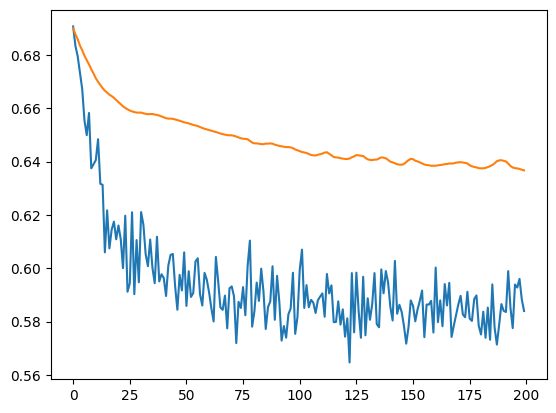

In [27]:
num_epochs=np.linspace(0,199,200)
plt.plot(num_epochs,Train_loss_lsts)
plt.plot(num_epochs,Test_loss_lsts)
plt.show()

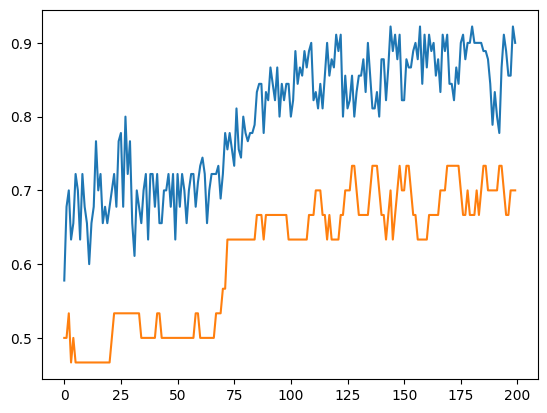

In [28]:
num_epochs=np.linspace(0,199,200)
plt.plot(num_epochs,Train_acc)
plt.plot(num_epochs,Test_acc)
plt.show()